In [111]:
log_path = "/Users/armaan/Desktop/imc-prosperity-quant-nyc/submissions/2024-04-23_22-21-30.log"

In [112]:
import re
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from scipy.stats import kurtosis, normaltest, skew


def read_file_sections(filepath):
    section_delimiters = ["Sandbox logs:", "Activities log:", "Trade History:"]
    current_section = None
    data = {key: [] for key in section_delimiters}

    with open(filepath, "r") as file:
        for line in file:
            line = line.strip()
            if line in section_delimiters:
                current_section = line
                continue
            if current_section:
                data[current_section].append(line)

    return data


def extract_trades(text):
    # Regex to find all blocks enclosed in curly braces
    trade_pattern = r"\{[^{}]*\}"
    # Regex to extract key-value pairs within curly braces
    kv_pattern = r"\"(\w+)\":\s*(\"[^\"]*\"|\d+)"

    trades = []
    matches = re.findall(trade_pattern, text)
    for match in matches:
        trade_data = {}
        for key, value in re.findall(kv_pattern, match):
            if value.startswith('"') and value.endswith('"'):
                value = value.strip('"')
            else:
                value = int(value)
            trade_data[key] = value
        trades.append(trade_data)
    return trades


sections = read_file_sections(log_path)
activities_data = "\n".join(sections["Activities log:"])
activities_df = pd.read_csv(StringIO(activities_data), delimiter=";")
trade_history_text = "\n".join(sections["Trade History:"])
trades = extract_trades(trade_history_text)
trade_history_df = pd.DataFrame(trades)

# comment out to use current live submiision

In [113]:
activities_df = pd.read_csv("/Users/armaan/Desktop/imc-prosperity-quant-nyc/data_bottles/round-3-island-data-bottle/prices_round_3_day_1.csv", sep=";")

In [114]:
df = activities_df[["timestamp", "product", "mid_price", "profit_and_loss"]]

df = df.pivot_table(
    index="timestamp",
    columns="product",
    values=["mid_price", "profit_and_loss"],
    aggfunc="mean",
).reset_index()

df.columns = [
    f"{col[1].lower()}_{col[0]}" if col[1] else col[0] for col in df.columns
]

Option Premium - Intrinsic Value = Time Value + Implied Volatility

In [115]:
df = df[["timestamp","gift_basket_mid_price", "roses_mid_price", "strawberries_mid_price", "chocolate_mid_price"]]

In [116]:
volume_data = trade_history_df.groupby(['timestamp', 'symbol'])['quantity'].sum().unstack(fill_value=0)
volume_data.columns = [f"{col.lower()}_volume" for col in volume_data.columns]
df = df.merge(volume_data, on='timestamp', how='left').fillna(0)


In [117]:
df["arbitrage_basket_mid_price"] = (
    4 * df["chocolate_mid_price"]
    + 6 * df["strawberries_mid_price"]
    + 1 * df["roses_mid_price"]
)

df["gift_basket_premium_mid_price"] = (
    df["gift_basket_mid_price"] - df["arbitrage_basket_mid_price"]
)



# Calculate moving averages
df["MA_SHORT"] = df["gift_basket_premium_mid_price"].rolling(window=59).mean()
df["MA_LONG"] = df["gift_basket_premium_mid_price"].rolling(window=110).mean()


# Buy Signal Enhanced
df["Buy_signal"] = (
    (df["MA_SHORT"] < df["MA_LONG"])  # Undervalued

)

# Sell Signal Enhanced
df["Sell_signal"] = (
    (df["MA_SHORT"] > df["MA_LONG"])  # Overvalued
    # & (df["RSI"] > 70)  # Overbought
    # # & (df["MACD"] - 2 < df["MACD_signal"])  # MACD crossover
)

<AxesSubplot: >

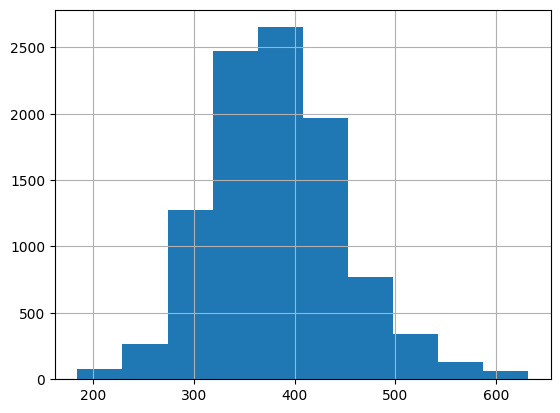

In [118]:
df["gift_basket_premium_mid_price"].hist()

In [119]:
BASE_ASSET = "gift_basket_mid_price"

In [120]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot layout: 2 rows, 1 column
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,  # Adjust space between plots
    subplot_titles=(
        f"{BASE_ASSET} Mid Price with Moving Averages",
        "Gift Basket Premium Spread",
    ),
)

# Add the main price chart to the first subplot
fig.add_trace(
    go.Scatter(
        x=df["timestamp"],
        y=df[BASE_ASSET],
        mode="lines",
        name=f"{BASE_ASSET} Mid Price",
    ),
    row=1,
    col=1,
)

# Adding moving averages
fig.add_trace(
    go.Scatter(
        x=df["timestamp"],
        y=df["MA_SHORT"],
        mode="lines",
        name="SHORT MA",
        line=dict(color="blue", dash="dash"),  # Blue dashed line
    ),
    row=2,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=df["timestamp"],
        y=df["MA_LONG"],
        mode="lines",
        name="LONG MA",
        line=dict(color="green", dash="dash"),  # Green dashed line
    ),
    row=2,
    col=1,
)

# Adding buy and sell signals
fig.add_trace(
    go.Scatter(
        x=df[df["Buy_signal"]]["timestamp"],
        y=df[df["Buy_signal"]][BASE_ASSET],
        mode="markers",
        marker=dict(color="green", size=10, symbol="triangle-up"),
        name="Buy Signal",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=df[df["Sell_signal"]]["timestamp"],
        y=df[df["Sell_signal"]][BASE_ASSET],
        mode="markers",
        marker=dict(color="red", size=10, symbol="triangle-down"),
        name="Sell Signal",
    ),
    row=1,
    col=1,
)

# Add the Gift Basket Premium Spread to the second subplot
fig.add_trace(
    go.Scatter(
        x=df["timestamp"],
        y=df["gift_basket_premium_mid_price"],
        mode="lines",
        name="Premium Mid Price",
        line=dict(color="orange"),
    ),
    row=2,
    col=1,
)


# Update layout for better visual alignment and readability
fig.update_layout(
    title=f"{BASE_ASSET} Mid Price with Trading Signals and Premium Spread",
    xaxis_title="Timestamp",
    yaxis_title="Mid Price",
    yaxis2_title="Premium Spread",
    showlegend=True,
    height=800,  # Adjust the height to accommodate both plots
    font=dict(family="Courier New, monospace", size=14, color="RebeccaPurple"),
)

fig.show()

---

In [121]:
df = df[["timestamp", "gift_basket_mid_price", "Buy_signal", "Sell_signal"]]
df["Signal"] = df["Buy_signal"].astype(int) - df["Sell_signal"].astype(int)

# Initialize the 'Modified_Signal' column
df["Modified_Signal"] = 0
current_signal = 0  # Track the current signal state
holding_signal = False  # This flag checks if we are in a holding state after a signal

for index, row in df.iterrows():
    if row["Signal"] != 0:
        if (
            row["Signal"] == current_signal
        ):  # If the signal is the same as current, continue holding
            df.at[index, "Modified_Signal"] = 0
        else:  # If the signal has changed
            current_signal = row["Signal"]  # Update current signal
            holding_signal = True  # Enable holding state
            df.at[index, "Modified_Signal"] = current_signal
    else:
        if holding_signal:  # If we are holding after a signal
            df.at[index, "Modified_Signal"] = 0
        else:
            df.at[index, "Modified_Signal"] = (
                0  # Continue neutral if no new signal has appeared
            )

    # Reset the holding signal if the current signal is opposite of the last non-zero signal
    if row["Signal"] != 0 and row["Signal"] != current_signal:
        holding_signal = False  # Reset holding state

TRADE_SIZE = 60
df["signed_quantity"] = df["Modified_Signal"] * TRADE_SIZE
df["cum_qty"] = df["signed_quantity"].cumsum()
df["cash_value"] = (-df["gift_basket_mid_price"] * df["signed_quantity"]).cumsum()
final_cash_value = df.iloc[-1]["cash_value"]
final_qty = df.iloc[-1]["cum_qty"]
liq_val = df.iloc[-1]["gift_basket_mid_price"]
net_pnl = final_cash_value + (final_qty * liq_val)
print(f"Net P&L = {net_pnl}")

Net P&L = 8160.0
